In [1]:
# imports

import os
import os.path
import cv2
import glob
import h5py
import tqdm
import argparse
import logging
from PIL import Image 

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns
sns.set_theme()
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import sys
sys.path.append('../')
import data, utils, models

In [2]:
# necessary variable definitions

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
transform = transforms.Compose([transforms.ToPILImage()])
to_gray = transforms.Compose([transforms.ToPILImage(), transforms.Grayscale(num_output_channels=1)])

dataset = "GoPro"
video = "rafting"
patch_size = 128
stride = 64
is_image = False
n_frames = 5
cpf = 3
mid = n_frames // 2
is_real = False

aug = 0

dist = 'G'
mode = 'S'
# change noise_std parameter here to produce results at various noise levels
noise_std = 30
min_noise = 0
max_noise = 100

batch_size = 1
lr = 1e-4

In [3]:
# data loader

PATH = os.path.join("../datasets/Set8", dataset)

train_loader, test_loader = data.build_dataset("SingleVideo", PATH, batch_size=batch_size, dataset=dataset, video=video, image_size=patch_size, stride=stride, n_frames=n_frames, 
                                               aug=aug, dist=dist, mode=mode, noise_std=noise_std, min_noise=min_noise, max_noise=max_noise,
                                               sample=True)

In [4]:
# frame to denoise

C, H, W = test_loader.dataset[0][0].shape

num = 15
x = 0; y = 0; w = W; h = H

images = []
psnrs = []
ssims = []

sample, noisy_inputs = test_loader.dataset[num]
sample = sample[:, y:y+h, x:x+w].unsqueeze(0).to(device)
noisy_inputs = noisy_inputs[:, y:y+h, x:x+w].unsqueeze(0).to(device)
 
# For sampling independent new nooise
# noisy_inputs = sample + utils.get_noise(sample, noise_std=noise_std)

N, C, H, W = sample.shape
clean_image = sample[:, 6:9, :, :]
noisy_frame = noisy_inputs[:, 6:9, :, :]

images.append(np.array(transform(clean_image[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, clean_image, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, clean_image, normalized=True, raw=False))

images.append(np.array(transform(noisy_frame[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, noisy_frame, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, noisy_frame, normalized=True, raw=False))

/ext3/anaconda3/lib/python3.8/site-packages/skimage/metrics/simple_metrics.py:160: RuntimeWarning: divide by zero encountered in double_scalars
  return 10 * np.log10((data_range ** 2) / err)


In [5]:
# FastDVDnet

PATH = "../pretrained/fast_dvd_net.pth"
model = utils.load_model(PATH, Fast=True).to(device).eval()

noise_map = (noise_std/255)*torch.ones(N, 1, H, W).to(device)

with torch.no_grad():
    output = model(noisy_inputs, noise_map)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [6]:
# MF2F

PATH = "../pretrained/mf2f_online_with_teacher_rafting_30.pth"
model = utils.load_model(PATH, Fast=True, mf2f=True).to(device).eval()

noise_map = (noise_std/255)*torch.ones(N, 1, H, W).to(device)

with torch.no_grad():
    output = model(noisy_inputs, noise_map)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [7]:
# UDVD (1 Frame)

PATH = "../pretrained/blind_spot_net.pt"
model, _, _ = utils.load_model(PATH, parallel=True)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_frame)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [8]:
# UDVD

PATH = "../pretrained/blind_video_net.pt"
model, _, _ = utils.load_model(PATH, parallel=True)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_inputs)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

In [9]:
# UDVD-S (single video)

PATH = "../pretrained/single_video_Set8_rafting_30.pt"

model, _, _ = utils.load_model(PATH, parallel=True, old=False)
model.to(device).eval()

with torch.no_grad():
    output, _ = model(noisy_inputs)
    output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)

images.append(np.array(transform(output[0].cpu().detach())))
psnrs.append(utils.psnr(clean_image, output, normalized=True, raw=False))
ssims.append(utils.ssim(clean_image, output, normalized=True, raw=False))

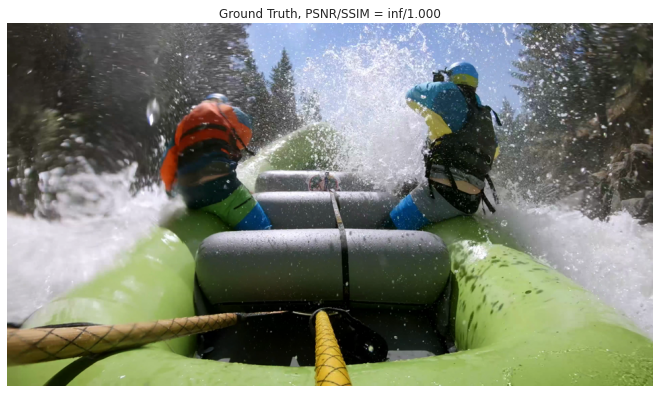

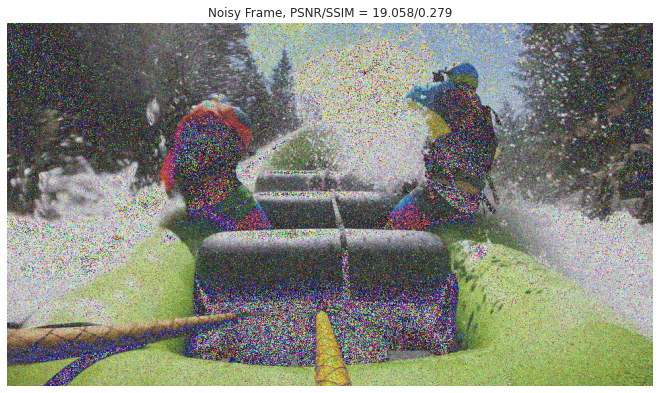

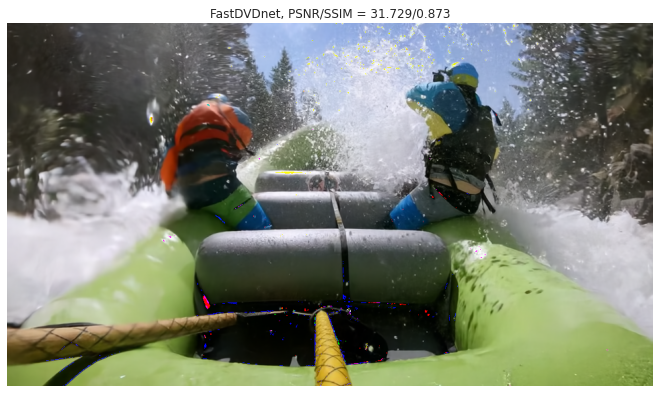

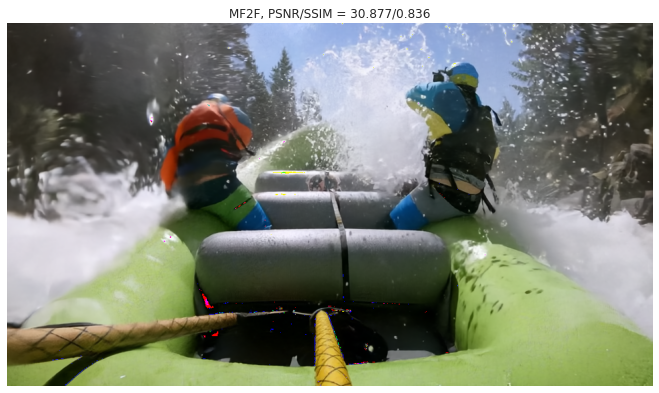

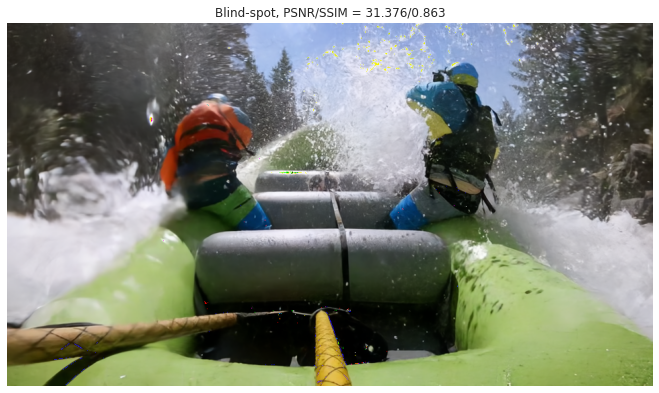

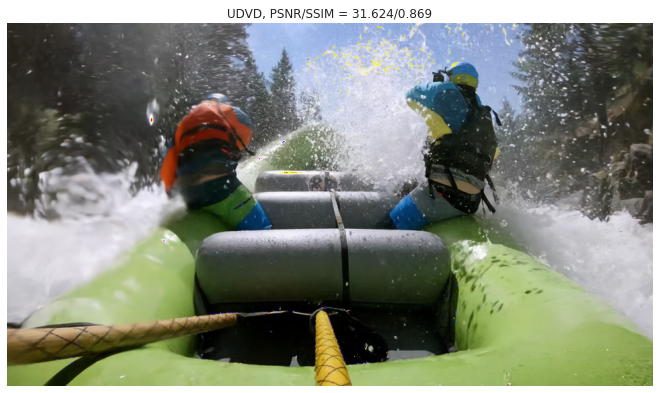

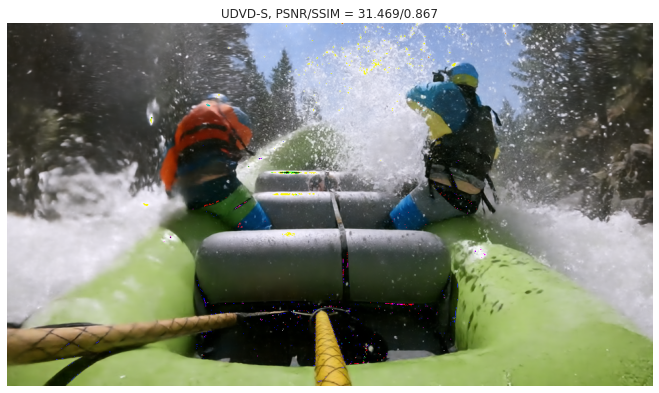

In [10]:
# plotting all images for comparison

names = ["Ground Truth", "Noisy Frame", "FastDVDnet", "MF2F", "Blind-spot", "UDVD", "UDVD-S"]

for i in range(len(names)):
    fig, ax = plt.subplots(figsize=(10, (9/16)*10))
    
    ax.imshow(images[i])
    ax.set_title("%s, PSNR/SSIM = %.3f/%.3f" % (names[i], psnrs[i], ssims[i]))
    ax.axis("off")
    
    plt.tight_layout()

In [11]:
# UDVD - example video gif
# Change model definition according to the code above for denoised videos of different models

PATH = "../pretrained/blind_video_net.pt"
model, _, _ = utils.load_model(PATH, parallel=True)
model.to(device).eval()

frames = []
os.makedirs(os.path.join("../examples", video), exist_ok=True)
save_dir = os.path.join("../examples", video)
C, H, W = test_loader.dataset[0][0].shape
w = W; h = H; x = 0; y = 0

with torch.no_grad():
    for i, (sample, noisy_inputs) in enumerate(test_loader):
        sample = sample[:,:,y:y+h,x:x+w].to(device)
        noisy_inputs = noisy_inputs[:,:,y:y+h,x:x+w].to(device)
        
        N, C, H, W = sample.shape
        clean_image = sample[:, 6:9, :, :]
        noisy_frame = noisy_inputs[:, 6:9, :, :]
        
        output, _ = model(noisy_inputs)
        output, mean_image = utils.post_process(output, noisy_frame, model = "blind-video-net", sigma = noise_std/255, device=device)
        
        img = np.array(transform(output[0].cpu().detach()))
        noisy_img = np.array(transform(noisy_frame[0].cpu().detach()))
        
        frame = cv2.cvtColor(np.append(noisy_img, img, axis=0), cv2.COLOR_RGB2BGR)
        
        cv2.line(frame, (0,H), (W,H), (0,0,255), 1)
        
        cv2.imwrite(os.path.join(save_dir, "%05d.jpg" % (i)), frame)
        
        frames.append(frame)

In [12]:
# combining frames into mp4 video

fps = 30
video_path = os.path.join(save_dir, f"{video}.mp4")
height, width, layers = frames[0].shape
out = cv2.VideoWriter(video_path, cv2.VideoWriter_fourcc(*'MJPG'), fps, (width, height))
for i in range(len(frames)):
    out.write(frames[i])
out.release()
cv2.destroyAllWindows()

In [13]:
# converting mp4 to a gif video (optional)

from moviepy.editor import *

video_path = os.path.join(save_dir, f"{video}.mp4")
gif_path = os.path.join(save_dir, f"{video}.gif")

clip = (VideoFileClip(video_path).resize(0.5))
clip.write_gif(gif_path)

t:   7%|▋         | 2/30 [00:00<00:02, 11.56it/s, now=None]

MoviePy - Building file ../examples/rafting/rafting.gif with imageio.
